In [1]:
cd /data/trungnv/Face_Recognition/

/data/trungnv/Face_Recognition


In [2]:
from __future__ import print_function, division

import torch
import numpy as np
import torchvision
from torchvision import datasets, transforms
import os
import net

from tqdm import *

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%%time

os.environ['CUDA_VISIBLE_DEVICES']='0'
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2022-08-04 12:54:36.726344: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


CPU times: user 1.83 s, sys: 311 ms, total: 2.14 s
Wall time: 14.2 s


In [4]:
%%time

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = transforms.Compose([
        transforms.Resize(112),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])


data_dir = 'VN_Celeb_blur/'
image_datasets = datasets.ImageFolder(data_dir, data_transforms)
dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=32,
                                             shuffle=False, num_workers=16)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CPU times: user 127 ms, sys: 20.4 ms, total: 147 ms
Wall time: 418 ms


In [5]:
%%time

index_same_class = np.load("index_same_class_VN_Celeb.npy", allow_pickle=False)
index_diff_class = np.load("index_diff_class_VN_Celeb.npy", allow_pickle=False)

CPU times: user 5.57 ms, sys: 30.2 s, total: 30.2 s
Wall time: 53.1 s


In [6]:
# Function Calculate Similarity Score

# Compare Score and Threshold
def check(score, threshold):
    if score > threshold:
        return 1
    else:
        return 0

    
def find_accuracy_with_threshold(THRESHOLD, similary_score):
    ground_truth = []
    predict = []
    scores = []

    len_same = len(index_same_class)

    for i in range(len_same):
        j, k = index_same_class[i]
        m, n = index_diff_class[i]
        score = similary_score[j, k]
        scores.append(score)
        ground_truth.append(1 if labels[k] == labels[j] else 0)
        predict.append(check(score, THRESHOLD))
        
        score = similary_score[m, n]
        scores.append(score)
        ground_truth.append(1 if labels[m] == labels[n] else 0)
        predict.append(check(score, THRESHOLD))
  
    tn, fp, fn, tp = confusion_matrix(ground_truth, predict).ravel()
    precision = tp/(fp+tp)
    recall = tp/(fn+tp)
    f1_score = 2*precision*recall/(precision + recall)

    ground_truth = np.array(ground_truth)
    predict = np.array(predict)
    accuracy = metrics.accuracy_score(ground_truth, predict)       
    return accuracy, precision, recall, f1_score

In [24]:
def plot_confusion_matrix_with_threshold(THRESHOLD, similary_score):
    ground_truth = []
    predict = []
    scores = []

    len_same = len(index_same_class)

    for i in range(len_same):
        j, k = index_same_class[i]
        m, n = index_diff_class[i]
        score = similary_score[j, k]
        scores.append(score)
        ground_truth.append(1 if labels[k] == labels[j] else 0)
        predict.append(check(score, THRESHOLD))
        
        score = similary_score[m, n]
        scores.append(score)
        ground_truth.append(1 if labels[m] == labels[n] else 0)
        predict.append(check(score, THRESHOLD))

        
    cm = confusion_matrix(ground_truth, predict)
    cm_11 = cm[1][1]     # backup value in cm[1][1]
    cm[1][1] = cm[0][0]  # swap
    cm[0][0] = cm_11     # swap
    cm_01 = cm[0][1]
    cm[0][1] = cm[1][0]
    cm[1][0] = cm_01
        
    group_names = ['True Positive', 'False Negative', 'False Positive', 'True Negative']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    axis = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    axis = np.asarray(axis).reshape(2,2)
    
    ax = sns.heatmap(cm, annot=axis, fmt='', cmap='Blues')

    plt.yticks([1.5, 0.5], ['0', '1'], ha='right')
    plt.xticks([1.5, 0.5], ['0', '1'], ha='right')

    ax.xaxis.set_ticklabels(['Negative', 'Positive'])
    ax.yaxis.set_ticklabels(['Negative', 'Positive'])
    plt.show()


def plot_metrics(THRESHOLD, PRECISION, RECALL, F1_SCORE):
    plt.plot(THRESHOLD, PRECISION, 'y', label="precision")
    plt.plot(THRESHOLD, RECALL, 'g', label="recall")
    plt.plot(THRESHOLD, F1_SCORE, 'c', label="f1_score")
    
    F1_SCORE = np.array(F1_SCORE)
    best_threshold = THRESHOLD[np.argmax(F1_SCORE)]
    best_f1_score = np.max(F1_SCORE)
    
    plt.plot(best_threshold, best_f1_score, 'xr', label="best_f1_score")
    plt.title("Plot Metrics")
    plt.xlabel("Threshold")
    plt.ylabel("Value")
    plt.grid()
    plt.legend()
    plt.vlines(best_threshold, 0, best_f1_score, linestyle="dashed")
    plt.hlines(best_f1_score, 0, best_threshold, linestyle="dashed")
    plt.scatter(best_threshold, best_f1_score, zorder=2)

    plt.xlim(0,None)
    plt.ylim(0,None)
    
    print("Best F1_Score: ", round(best_f1_score*100, 2))
    print("Best Threshold: ", round(best_threshold, 3))
    return best_threshold


## Pretrain

In [8]:
%%time

# Load model

adaface_models = {
    'ir_101':"pretrained/adaface_ir101_webface12m.ckpt",
}

architecture='ir_101'

# load model and pretrained statedict
assert architecture in adaface_models.keys()
model = net.build_model(architecture)
statedict = torch.load(adaface_models[architecture])['state_dict']
model_statedict = {key[6:]:val for key, val in statedict.items() if key.startswith('model.')}
model.load_state_dict(model_statedict)
model.eval()

model.cuda()

CPU times: user 4.95 s, sys: 2.81 s, total: 7.76 s
Wall time: 15 s


Backbone(
  (input_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=64)
  )
  (output_layer): Sequential(
    (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.4, inplace=False)
    (2): Flatten()
    (3): Linear(in_features=25088, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  )
  (body): Sequential(
    (0): BasicBlockIR(
      (shortcut_layer): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
      (res_layer): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [9]:
%%time

from tqdm import *

i = 0
for inputs, label in tqdm(dataloaders):
    i+=1
    inputs = inputs.to(device)
    label = label.to(device).detach().cpu().clone().numpy()
    feature = model(inputs).detach().cpu().clone().numpy()
    
    if i==1:
        features = np.array(feature)
        labels = np.array(label)

    else:
        features = np.append(features, feature, axis=0)
        labels = np.append(labels, label)
        
similary_score_pretrain = features @ features.T

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 723/723 [02:41<00:00,  4.48it/s]


CPU times: user 2min 35s, sys: 1h 1s, total: 1h 2min 36s
Wall time: 4min 17s


Best F1_Score:  85.27
Best Threshold:  0.13
CPU times: user 8min 22s, sys: 9.15 s, total: 8min 31s
Wall time: 8min 32s


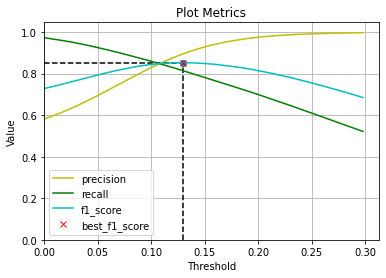

In [10]:
%%time
#adaface_ir101_webface12m - VN_Celeb_blur

ACCURACY_PRETRAIN = []
PRECISION_PRETRAIN = []
RECALL_PRETRAIN = []
F1_SCORE_PRETRAIN = []

for THRESHOLD in np.arange(0.00, 0.30, 0.002):
    accuracy, precision, recall, f1_score = find_accuracy_with_threshold(THRESHOLD, similary_score_pretrain)
    ACCURACY_PRETRAIN.append(accuracy)
    PRECISION_PRETRAIN.append(precision)
    RECALL_PRETRAIN.append(recall)
    F1_SCORE_PRETRAIN.append(f1_score)
    
THRESHOLD = np.arange(0.00, 0.30, 0.002)  

best_threshold = plot_metrics(THRESHOLD, PRECISION_PRETRAIN, RECALL_PRETRAIN, F1_SCORE_PRETRAIN)


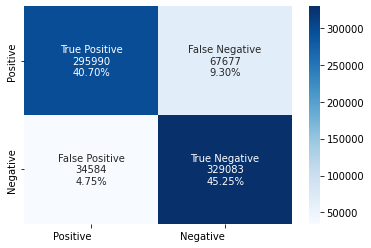

CPU times: user 3.24 s, sys: 367 ms, total: 3.61 s
Wall time: 3.43 s


In [25]:
%%time
plot_confusion_matrix_with_threshold(best_threshold, similary_score_pretrain)

## Finetune

In [12]:
%%time

# Load model

adaface_models = {
    'ir_101':"finetune/finetune_ir101_webface12m.ckpt",
}

architecture='ir_101'

# load model and pretrained statedict
assert architecture in adaface_models.keys()
model = net.build_model(architecture)
statedict = torch.load(adaface_models[architecture])['state_dict']
model_statedict = {key[6:]:val for key, val in statedict.items() if key.startswith('model.')}
model.load_state_dict(model_statedict)
model.eval()

model.cuda()

CPU times: user 1.51 s, sys: 356 ms, total: 1.86 s
Wall time: 2.59 s


Backbone(
  (input_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=64)
  )
  (output_layer): Sequential(
    (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.4, inplace=False)
    (2): Flatten()
    (3): Linear(in_features=25088, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  )
  (body): Sequential(
    (0): BasicBlockIR(
      (shortcut_layer): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
      (res_layer): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [13]:
%%time

from tqdm import *

i = 0
for inputs, label in tqdm(dataloaders):
    i+=1
    inputs = inputs.to(device)
    label = label.to(device).detach().cpu().clone().numpy()
    feature = model(inputs).detach().cpu().clone().numpy()
    
    if i==1:
        features = np.array(feature)
        labels = np.array(label)

    else:
        features = np.append(features, feature, axis=0)
        labels = np.append(labels, label)
        
similary_score_finetune = features @ features.T

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 723/723 [01:22<00:00,  8.74it/s]


CPU times: user 2min 14s, sys: 1h 2min 57s, total: 1h 5min 12s
Wall time: 3min 7s


Best F1_Score:  91.55
Best Threshold:  0.184
CPU times: user 8min 52s, sys: 6.35 s, total: 8min 58s
Wall time: 8min 59s


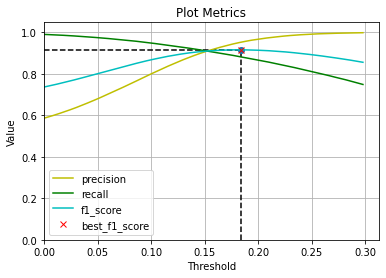

In [14]:
%%time
#finetune_ir101_webface12m - VN_Celeb_blur

ACCURACY_FINETUNE = []
PRECISION_FINETUNE = []
RECALL_FINETUNE = []
F1_SCORE_FINETUNE = []

for THRESHOLD in np.arange(0.00, 0.30, 0.002):
    accuracy, precision, recall, f1_score = find_accuracy_with_threshold(THRESHOLD, similary_score_finetune)
    ACCURACY_FINETUNE.append(accuracy)
    PRECISION_FINETUNE.append(precision)
    RECALL_FINETUNE.append(recall)
    F1_SCORE_FINETUNE.append(f1_score)
    
THRESHOLD = np.arange(0.00, 0.30, 0.002)  

best_threshold = plot_metrics(THRESHOLD, PRECISION_FINETUNE, RECALL_FINETUNE, F1_SCORE_FINETUNE)


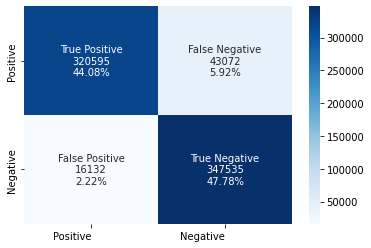

CPU times: user 3.19 s, sys: 288 ms, total: 3.47 s
Wall time: 3.23 s


In [26]:
%%time
plot_confusion_matrix_with_threshold(best_threshold, similary_score_finetune)